In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/GUITARS_DATASET.zip'

Archive:  /content/drive/My Drive/GUITARS_DATASET.zip
   creating: GUITARS_DATASET/
   creating: GUITARS_DATASET/masks/
  inflating: GUITARS_DATASET/masks/962.png  
  inflating: GUITARS_DATASET/masks/1017.png  
  inflating: GUITARS_DATASET/masks/1281.png  
  inflating: GUITARS_DATASET/masks/81.png  
  inflating: GUITARS_DATASET/masks/989.png  
  inflating: GUITARS_DATASET/masks/328.png  
  inflating: GUITARS_DATASET/masks/691.png  
  inflating: GUITARS_DATASET/masks/1438.png  
  inflating: GUITARS_DATASET/masks/1533.png  
  inflating: GUITARS_DATASET/masks/776.png  
  inflating: GUITARS_DATASET/masks/965.png  
  inflating: GUITARS_DATASET/masks/1733.png  
  inflating: GUITARS_DATASET/masks/1680.png  
  inflating: GUITARS_DATASET/masks/1358.png  
  inflating: GUITARS_DATASET/masks/748.png  
  inflating: GUITARS_DATASET/masks/808.png  
  inflating: GUITARS_DATASET/masks/1605.png  
  inflating: GUITARS_DATASET/masks/1357.png  
  inflating: GUITARS_DATASET/masks/1275.png  
  inflating: GUI

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
DATA_DIR = '/content/GUITARS_DATASET'

print(len(os.listdir(DATA_DIR+'/images')))
print(len(os.listdir(DATA_DIR+'/masks')))


1801
1801


In [ ]:
#imgs = os.listdir(DATA_DIR+'/images')
#masks = os.listdir(DATA_DIR+'/masks')

In [ ]:

image_list= os.listdir('/content/GUITARS_DATASET/images/')
masks_list = os.listdir('/content/GUITARS_DATASET/masks/')

len_data = len(image_list)
train_size = 0.9


'''
train_image_paths = folder_data[:1080]
test_image_paths = folder_data[int(len_data*train_size):]
train_mask_paths = folder_mask[:1080]
test_mask_paths = folder_mask[int(len_data*train_size):]
'''

print(image_list[0])
print(masks_list[0])


train_image_paths = image_list[:int(len_data*train_size)]
val_image_paths = image_list[int(len_data*train_size):]

train_masks_paths = masks_list[:int(len_data*train_size)]
val_masks_paths = masks_list[int(len_data * train_size):]

print(train_image_paths[0] == train_masks_paths[0])

print(len(train_image_paths),len(train_masks_paths))


print(len(val_masks_paths))
def check():
  counter = 0
  for i in range(len(train_image_paths)):  #1080
    if train_image_paths[i] != train_masks_paths[i]:
      counter+=1
      print("ar udris")
      print(i)
      print("counteri")
      print(counter)
      return False

  return True
      

print()

check()


1489.png
1489.png
True
1620 1620
181



True

In [ ]:
def create_dir(dirname):
  directory = dirname
  parent_dir = '/content/GUITARS_DATASET/'
  path = os.path.join(parent_dir,directory)
  os.mkdir(path)

In [ ]:
def copy_files_in_dir(file_type,destination,image_paths): #ex: type = /images/, filename = '/content/GUITARS_DATASET/train' anu saidanac minda kopireba
  import shutil
  for filename in image_paths:
    shutil.copy(DATA_DIR+'/'+file_type+'/'+filename,destination)

In [ ]:
create_dir('train')
create_dir('trainannot')

create_dir('val')
create_dir('valannot')

In [ ]:

copy_files_in_dir('images','/content/GUITARS_DATASET/train',train_masks_paths)
copy_files_in_dir('masks','/content/GUITARS_DATASET/trainannot',train_masks_paths)

copy_files_in_dir('images','/content/GUITARS_DATASET/val',val_image_paths)
copy_files_in_dir('masks','/content/GUITARS_DATASET/valannot',val_image_paths)

In [ ]:
#organising data

x_train_dir = os.path.join(DATA_DIR,'train')
y_train_dir = os.path.join(DATA_DIR,'trainannot')

x_test_dir = os.path.join(DATA_DIR,'val')
y_test_dir = os.path.join(DATA_DIR,'valannot')

In [ ]:
print(x_train_dir)
print(y_train_dir)
print(x_test_dir)
print(y_test_dir)

/content/GUITARS_DATASET/train
/content/GUITARS_DATASET/trainannot
/content/GUITARS_DATASET/val
/content/GUITARS_DATASET/valannot


In [ ]:

import albumentations as A
import cv2

_transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.2),
])


In [ ]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets,models

class SimDataset(Dataset):
  def __init__(self,images_dir,masks_dir,transform = None,augmentation = None):

    self.ids = os.listdir(images_dir)

    self.images_full_path = [os.path.join(images_dir,images_id) for images_id in self.ids]
    self.target_full_path = [os.path.join(masks_dir,images_id) for images_id in self.ids]

    
    self.transform = transform

  def __len__(self):
    return len(self.ids)

  def __getitem__(self,index):
    image = cv2.imread(self.images_full_path[index])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(512,512))

    mask = cv2.imread(self.target_full_path[index],0)
    mask = cv2.resize(mask,(512,512))

    #transformed = _transform(image=image, mask=mask)
    #transformed_image = transformed['image']
    #transformed_mask = transformed['mask']

    if self.transform:
      image = self.transform(image)
      transformed_mask = torch.from_numpy(mask.astype('float32')).unsqueeze(0)
    return [image,transformed_mask/255]


trans = transforms.Compose([           
                            transforms.ToTensor(),
                            transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
])


In [ ]:
train_set = SimDataset(x_train_dir,y_train_dir,transform=trans)
val_set = SimDataset(x_test_dir,y_test_dir,transform=trans)

In [ ]:
image_datasets = {
    'train':train_set,
    'val':val_set
}
batch_size  = 2

dataloaders = {
    'train':DataLoader(train_set,batch_size,shuffle=True),
    'val':DataLoader(val_set,batch_size,shuffle=True)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 1620, 'val': 181}

In [ ]:
import torchvision.utils
import torch
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp


inputs, masks = next(iter(dataloaders['train']))
print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())



plt.imshow(reverse_transform(inputs[3]))

torch.Size([2, 3, 512, 512]) torch.Size([2, 1, 512, 512])
-2.0357141 2.64 -0.40101826 0.9123442
0.0 1.0 0.23596875 0.42405066


IndexError: ignored

In [ ]:
plt.imshow(img.permute(1,2,0))


NameError: ignored

In [ ]:
from torchvision import models

base_model = models.resnet18(pretrained=False)

list(base_model.children())


In [ ]:
import torch
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

summary(base_model, input_size=(3, 736 , 736))

In [ ]:
import torch
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        #
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [ ]:

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(1)
model = model.to(device)

summary(model, input_size=(3, 736, 736))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 736, 736]           1,792
              ReLU-2         [-1, 64, 736, 736]               0
            Conv2d-3         [-1, 64, 736, 736]          36,928
              ReLU-4         [-1, 64, 736, 736]               0
            Conv2d-5         [-1, 64, 368, 368]           9,408
       BatchNorm2d-6         [-1, 64, 368, 368]             128
              ReLU-7         [-1, 64, 368, 368]               0
         MaxPool2d-8         [-1, 64, 184, 184]               0
            Conv2d-9         [-1, 64, 184, 184]          36,864
      BatchNorm2d-10         [-1, 64, 184, 184]             128
             ReLU-11         [-1, 64, 184, 184]               0
           Conv2d-12         [-1, 64, 184, 184]          36,864
      BatchNorm2d-13         [-1, 64, 184, 184]             128
             ReLU-14         [-1, 64, 1

In [ ]:
 
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import torch
#from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)      
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))  

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = ResNetUNet(num_class).to(device)

# freeze backbone layers
# Comment out to finetune further
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4,momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)

cuda:0
Epoch 0/19
----------
LR 0.0001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train: bce: 0.594165, dice: 0.827309, loss: 0.710737
val: bce: 0.530559, dice: 0.827848, loss: 0.679204
saving best model
12m 13s
Epoch 1/19
----------
LR 0.0001
train: bce: 0.462992, dice: 0.844524, loss: 0.653758
val: bce: 0.421344, dice: 0.831630, loss: 0.626487
saving best model
12m 15s
Epoch 2/19
----------
LR 0.0001
train: bce: 0.396227, dice: 0.830436, loss: 0.613331
val: bce: 0.385012, dice: 0.805482, loss: 0.595247
saving best model
12m 15s
Epoch 3/19
----------
LR 0.0001
train: bce: 0.358327, dice: 0.795291, loss: 0.576809
val: bce: 0.350285, dice: 0.762805, loss: 0.556545
saving best model
12m 13s
Epoch 4/19
----------
LR 0.0001
train: bce: 0.309056, dice: 0.750549, loss: 0.529802
val: bce: 0.298103, dice: 0.713124, loss: 0.505614
saving best model
12m 15s
Epoch 5/19
----------
LR 0.0001
train: bce: 0.270083, dice: 0.696427, loss: 0.483255
val: bce: 0.278221, dice: 0.667643, loss: 0.472932
saving best model
12m 13s
Epoch 6/19
----------
LR 0.0001
train: bce: 0.261227, dice: 

In [ ]:
!wget https://images.reverb.com/image/upload/s--hCvA1Gix--/f_auto,t_large/v1559759198/bghge6q0jidiwxumevwe.png

--2020-09-17 13:36:32--  https://images.reverb.com/image/upload/s--hCvA1Gix--/f_auto,t_large/v1559759198/bghge6q0jidiwxumevwe.png
Resolving images.reverb.com (images.reverb.com)... 104.68.82.93, 2a02:26f0:6b:583::29cc, 2a02:26f0:6b:5b6::29cc
Connecting to images.reverb.com (images.reverb.com)|104.68.82.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29727 (29K) [image/jpeg]
Saving to: ‘bghge6q0jidiwxumevwe.png’

bghge6q0jidiwxumevw 100%[===================>]  29.03K  --.-KB/s    in 0.008s  

2020-09-17 13:36:32 (3.68 MB/s) - ‘bghge6q0jidiwxumevwe.png’ saved [29727/29727]



In [ ]:
import math

model.eval()   # Set model to evaluate mode

# test_dataset = Dataset(, transform = trans)
# test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
# inputs, labels = next(iter(test_loader))
# inputs = inputs.to(device)
# labels = labels.to(device)

# pred = model(inputs)
# pred = torch.sigmoid(pred)
# pred = pred.data.cpu().numpy()
# print(pred.shape)







    # image = cv2.imread(self.images_full_path[index])
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image,(288,288))

    # mask = cv2.imread(self.target_full_path[index],0)
    # mask = cv2.resize(mask,(288,288))


    # if self.transform:
    #   image = self.transform(image)
    #   mask = torch.from_numpy(mask.astype('float32')).unsqueeze(0)

      


    # return [image,mask/255]

trans = transforms.Compose([                     
                            transforms.ToTensor(),
                            transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
])



img = cv2.imread("test.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(288,288))
img = trans(img)
img = img.unsqueeze(0).to(device)
# img = img.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])


pred = model(img)

pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
pred.shape


(1, 1, 288, 288)

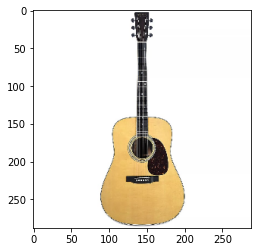

In [ ]:
img = cv2.imread("test.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
image = cv2.resize(img,(288,288))
plt.imshow(image)

In [ ]:
pred = pred.squeeze(0) #numpy albat

In [ ]:
pred = pred.squeeze(0)

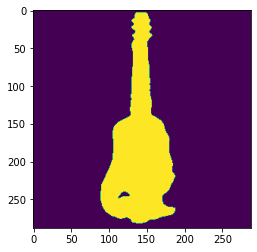

In [ ]:
plt.imshow(pred > 0.06)

In [ ]:
image.shape

(288, 288, 3)

In [ ]:
pred = np.expand_dims(pred,axis=2)

In [ ]:
pred.shape

(288, 288, 1)

SystemError: ignored

In [ ]:
res = cv2.bitwise_and(image,image,mask = pred)

error: ignored